In [1]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle
import wrds

In [2]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [3]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [4]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy = processor.column_date_processing(spy)
spy = spy.sort_values("date")
fred.disconnect()

In [5]:
unneeded_columns = ["ticker","year","quarter","gsector","gicdesc","y"]

In [6]:
market.connect()
sec.connect()
factors_df = []
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = processor.column_date_processing(sec.query("financials",{"ticker":ticker})).drop(["gsector","gicdesc"],axis=1)
        filings["year"] = [x.year for x in filings["date"]]
        filings["quarter"] = [x.quarter for x in filings["date"]]
        filings["quarter"] = filings["quarter"].shift(1)
        price = price.drop(["date","ticker"],axis=1).merge(filings.drop(["date","ticker"],axis=1),on=["year","quarter"],how="left").groupby(["year","quarter"]).mean().reset_index()
        price["ticker"] = ticker
        price["y"] = price["adjclose"].shift(-4)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()

  4%|███▊                                                                                      | 21/503 [00:02<00:40, 11.79it/s]

GOOGL 'date'


 11%|█████████▋                                                                                | 54/503 [00:05<00:44,  9.99it/s]

AVB 'date'


 13%|███████████▍                                                                              | 64/503 [00:06<00:37, 11.71it/s]

BRK.B 'date'


 16%|██████████████▎                                                                           | 80/503 [00:07<00:37, 11.34it/s]

BF.B 'date'


 16%|██████████████▋                                                                           | 82/503 [00:08<00:36, 11.54it/s]

BXP 'date'


 18%|████████████████                                                                          | 90/503 [00:08<00:39, 10.33it/s]

CCL 'date'


 26%|███████████████████████▎                                                                 | 132/503 [00:12<00:31, 11.88it/s]

CPAY 'date'


 29%|█████████████████████████▍                                                               | 144/503 [00:14<00:33, 10.64it/s]

DAY 'date'


 30%|██████████████████████████▉                                                              | 152/503 [00:14<00:31, 11.15it/s]

DLR 'date'


 36%|███████████████████████████████▊                                                         | 180/503 [00:17<00:29, 10.99it/s]

EQR 'date'
ESS 'date'


 37%|████████████████████████████████▌                                                        | 184/503 [00:17<00:27, 11.63it/s]

EG 'date'


 39%|██████████████████████████████████▎                                                      | 194/503 [00:18<00:28, 10.66it/s]

FRT 'date'


 43%|█████████████████████████████████████▊                                                   | 214/503 [00:20<00:21, 13.58it/s]

GEV 'date'


 52%|██████████████████████████████████████████████▌                                          | 263/503 [00:25<00:21, 11.42it/s]

IVZ 'date'
INVH 'date'


 53%|███████████████████████████████████████████████▌                                         | 269/503 [00:26<00:21, 10.73it/s]

JCI 'date'


 55%|█████████████████████████████████████████████████▎                                       | 279/503 [00:27<00:18, 11.82it/s]

KIM 'date'


 59%|████████████████████████████████████████████████████▉                                    | 299/503 [00:28<00:17, 11.43it/s]

LYB 'date'


 64%|█████████████████████████████████████████████████████████▏                               | 323/503 [00:31<00:16, 10.86it/s]

MAA 'date'


 69%|█████████████████████████████████████████████████████████████▊                           | 349/503 [00:34<00:14, 10.50it/s]

NCLH 'date'


 70%|██████████████████████████████████████████████████████████████▍                          | 353/503 [00:34<00:13, 10.89it/s]

NXPI 'date'


 79%|██████████████████████████████████████████████████████████████████████▌                  | 399/503 [00:39<00:09, 10.48it/s]

REG 'date'


 82%|████████████████████████████████████████████████████████████████████████▌                | 410/503 [00:40<00:09,  9.37it/s]

RCL 'date'


 82%|████████████████████████████████████████████████████████████████████████▉                | 412/503 [00:40<00:08, 10.23it/s]

SLB 'date'


 91%|█████████████████████████████████████████████████████████████████████████████████▍       | 460/503 [00:45<00:03, 11.88it/s]

UDR 'date'


 94%|███████████████████████████████████████████████████████████████████████████████████▎     | 471/503 [00:46<00:02, 11.42it/s]

VLTO 'date'


 95%|████████████████████████████████████████████████████████████████████████████████████▍    | 477/503 [00:46<00:01, 13.08it/s]

VICI 'date'


100%|█████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:49<00:00, 10.15it/s]

ZTS 'date'


In [7]:
factors_df = pd.concat(factors_df)

In [8]:
for column in factors_df:
    if column in factors_df[column]:
        factors_df.drop(column,axis=1,inplace=True)

In [9]:
factors_df = factors_df.fillna(0)

In [26]:
factors_df[[x for x in factors_df.columns if x not in unneeded_columns]].corr()[["adjclose"]].sort_values("adjclose").head(20)

,adjclose
bm,-0.138310
divyield,-0.114676
volume,-0.060681
short_debt,-0.058944
equity_invcap,-0.057656
curr_debt,-0.056008
adjvolume,-0.049844
rect_act,-0.042651
curr_ratio,-0.042133
quick_ratio,-0.039520


In [44]:
model = XGBRegressor()
factors = ["ptb","roa","mktcap","bm","short_debt","volume","divyield","adjclose"]
factors_df.sort_values(["year","quarter"],inplace=True)
training_data = factors_df[(factors_df["year"]<2023)].dropna()
sim = factors_df[factors_df["year"]>=2023].drop("y",axis=1).dropna()
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])

In [45]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sp500[["ticker","GICS Sub-Industry"]],on="ticker",how="left")
        price["expected_return"] = (price["prediction"] - price["adjclose"]) / price["adjclose"]
        price["historical_return"] = price["adjclose"].pct_change(90)
        price["factor_return"] = price["spy"].pct_change(90)
        price["cov"] = price["factor_return"].rolling(100).cov(price["expected_return"])
        price["var"] = price["factor_return"].rolling(100).var()
        price["beta"] = price["cov"] / price["var"]
        price["excess_return"] = price["rf"] + price["beta"] * (price["expected_return"] - price["rf"])
        prices.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

 13%|███████████▍                                                                              | 64/503 [00:05<00:30, 14.30it/s]

BRK.B 'date'


 16%|██████████████▏                                                                           | 79/503 [00:06<00:31, 13.32it/s]

BF.B 'date'


100%|█████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:40<00:00, 12.41it/s]

ZTS 'date'


In [46]:
sim = pd.concat(prices).dropna()
sim["quarter"] = [x.quarter for x in sim["date"]]
sim = sim[sim["date"]>datetime(2024,1,1)]

In [64]:
sim

,date,close,high,low,open,volume,adjclose,adjhigh,adjlow,adjopen,...,spy,rf,GICS Sub-Industry,expected_return,historical_return,factor_return,cov,var,beta,excess_return
4854,2024-01-02,110.00,110.66,108.450,108.62,2776824,90.222153,90.763486,88.950841,89.090275,...,4742.83,0.0395,Industrial Conglomerates,0.001949,0.121164,0.069166,-0.004138,0.001801,-2.297420,0.125769
4855,2024-01-03,107.79,109.46,106.800,109.23,2966239,88.409508,89.779245,87.597509,89.590598,...,4704.81,0.0391,Industrial Conglomerates,0.022492,0.111465,0.075063,-0.004204,0.001789,-2.349655,0.078123
4856,2024-01-04,108.17,109.34,107.705,108.08,2775925,88.721185,89.680820,88.339791,88.647367,...,4688.68,0.0399,Industrial Conglomerates,0.018900,0.110311,0.064228,-0.004241,0.001775,-2.389451,0.090078
4857,2024-01-05,108.59,109.49,107.550,107.98,1646452,89.065669,89.803851,88.212660,88.565347,...,4697.24,0.0405,Industrial Conglomerates,0.014959,0.059276,0.059533,-0.004259,0.001744,-2.442513,0.102883
4858,2024-01-08,108.86,108.96,107.590,108.26,2119575,89.287124,89.369144,88.245468,88.795003,...,4763.54,0.0401,Industrial Conglomerates,0.012442,0.047325,0.059122,-0.004303,0.001724,-2.496132,0.109138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,2024-09-12,105.14,105.31,104.095,105.15,1436830,105.140000,105.310000,104.095000,105.150000,...,5595.76,0.0368,Health Care Equipment,0.163624,-0.133870,0.091262,-0.000016,0.000771,-0.020594,0.034188
5030,2024-09-13,106.26,107.94,105.200,105.20,1460491,106.260000,107.940000,105.200000,105.200000,...,5626.02,0.0366,Health Care Equipment,0.151360,-0.116656,0.085949,-0.000015,0.000771,-0.019776,0.034330
5031,2024-09-16,107.43,107.59,106.250,106.84,1261138,107.430000,107.590000,106.250000,106.840000,...,5633.09,0.0363,Health Care Equipment,0.138820,-0.113329,0.085855,-0.000011,0.000770,-0.014227,0.034841
5032,2024-09-17,106.24,107.79,104.485,107.43,1924845,106.240000,107.790000,104.485000,107.430000,...,5634.58,0.0365,Health Care Equipment,0.151576,-0.118942,0.086149,-0.000013,0.000770,-0.017349,0.034504


In [47]:
# Initialize variables
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 1
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
        }
        for _ in sp500["GICS Sub-Industry"].unique()
    ]
}
states = []
trades = []
annual_balance = 100000
prev_quarter = 0
quarter = 1
for date in sim.sort_values("date")["date"].unique():
    today = sim[sim["date"] == date].copy()
    prev_quarter = quarter
    quarter = date.quarter
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            for i in range(125):
                position = positions[i]
                sector = list(sp500["GICS Sub-Industry"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                positions[i] = position
            portfolio["positions"] = positions
            
            cash = portfolio["cash"]
            positions = copy.deepcopy(portfolio["positions"])
            
            for i in range(125):
                position = positions[i]
                sector = list(sp500["GICS Sub-Industry"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        notional = stock["pv"]
                        hpr = int((date - stock["buy_date"]).days)
                        opportunity_row = today[today["GICS Sub-Industry"] == sector].sort_values("expected_return", ascending=False).iloc[j]
                        opportunity_ticker = opportunity_row["ticker"]
                        if (hpr > 90):
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            stock = Stock.buy(opportunity_row, stock, notional)
                            stock["sector"] = sector
                            position["stocks"][j] = stock
                            positions[i] = position
                portfolio["positions"] = positions
            if date == sim["date"].min():
                for i in range(125):
                    notional = float(cash / 125 / number_of_stocks)
                    position = positions[i]
                    sector = list(sp500["GICS Sub-Industry"].unique())[i]
                    stocks = copy.deepcopy(position["stocks"])
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        row = today[today["GICS Sub-Industry"] == sector].sort_values("expected_return", ascending=False).iloc[j]
                        stock = Stock.buy(row, stock, notional)
                        stock["sector"] = sector
                        position["stocks"][j] = stock
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

Error on date 2024-01-02 00:00:00: single positional indexer is out-of-bounds


In [48]:
portfolios = []
for state in states:
    for i in range(125):
        for j in range(number_of_stocks):
            view = state["positions"][i]["stocks"][j]
            view["date"] = state["date"]
            portfolios.append(state["positions"][i]["stocks"][j])

In [49]:
performance = pd.DataFrame(portfolios).dropna()
performance = performance.groupby(["date","sector"]).agg({"pv":"sum"}).reset_index()
performance["stock_return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]

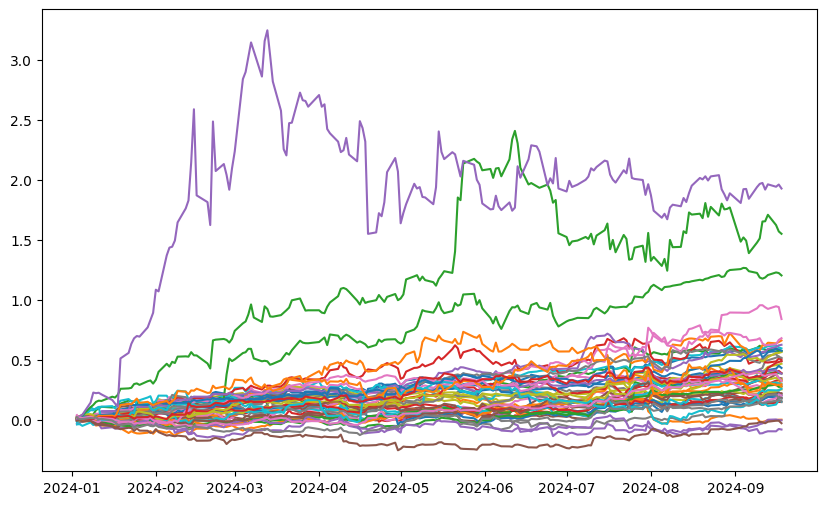

In [50]:
plt.figure(figsize=(10, 6))  
for sector in performance["sector"].unique():
    sector_perf = performance[performance["sector"]==sector]
    plt.plot(sector_perf["date"].values,sector_perf["stock_return"].values)
    # plt.legend(performance["sector"].unique())
plt.show()

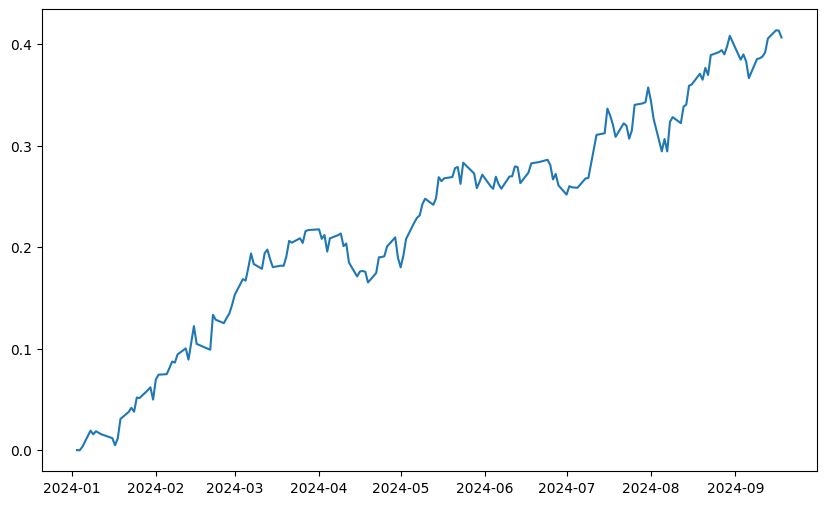

In [51]:
performance = performance.groupby(["date"]).agg({"pv":"sum"}).reset_index()
performance["stock_return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]
plt.figure(figsize=(10, 6)) 
plt.plot(performance["date"].values,performance["stock_return"].values)
plt.show()

In [52]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [53]:
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

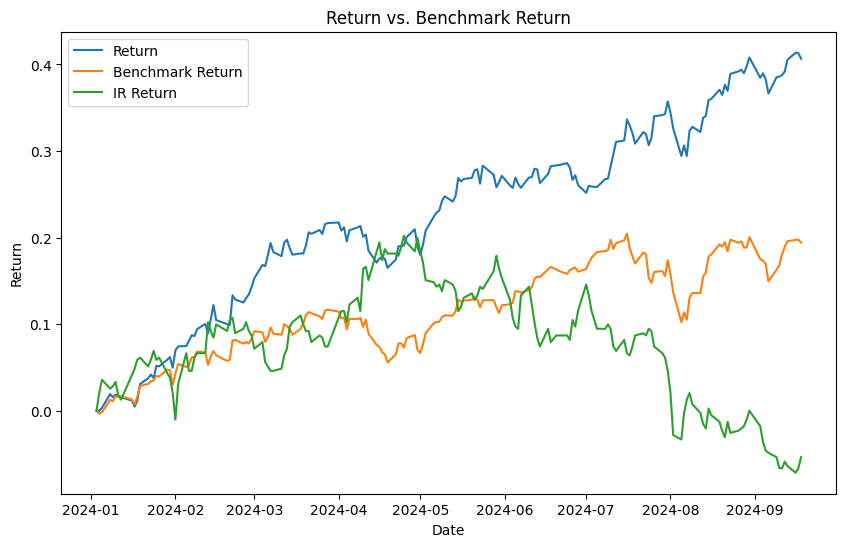

In [54]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [55]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

1.9470788384609086

In [56]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sub-Industry"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["hpr"] = t["sell_date"] - t["buy_date"]
t["hpr"] = [int(x.days) for x in t["hpr"]]

In [57]:
t.sort_values("return",ascending=False).head(30)

,ticker,adjclose,quantity,excess_return,buy_price,buy_date,sell_date,pv,sector,GICS Sub-Industry,return,hpr
33,SMCI,1009.910000,2.802592,-0.400534,285.450000,2024-01-02,2024-04-02,2830.366089,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",2.537958,91
6,NVDA,89.433980,16.612656,-0.265204,48.156056,2024-01-02,2024-04-02,1485.735962,Semiconductors,Semiconductors,0.857170,91
16,CEG,187.477277,6.979272,-0.121064,114.625137,2024-01-02,2024-04-02,1308.454892,Electric Utilities,Electric Utilities,0.635569,91
7,NRG,67.841341,15.905587,-0.033788,50.296793,2024-01-02,2024-04-02,1079.056322,Independent Power Producers & Energy Traders,Independent Power Producers & Energy Traders,0.348820,91
29,ETN,312.750796,3.380736,0.088439,236.634862,2024-01-02,2024-04-02,1057.327878,Electrical Components & Equipment,Electrical Components & Equipment,0.321660,91
32,FANG,196.062710,5.296806,0.096951,151.034404,2024-01-02,2024-04-02,1038.506221,Oil & Gas Exploration & Production,Oil & Gas Exploration & Production,0.298133,91
54,FSLR,216.730000,8.887575,-0.216343,167.170000,2024-04-02,2024-07-02,1926.204194,Semiconductors,Semiconductors,0.296465,91
34,LRCX,962.667287,1.075091,1.052532,744.123026,2024-01-02,2024-04-02,1034.954978,Semiconductor Materials & Equipment,Semiconductor Materials & Equipment,0.293694,91
37,ANET,290.850000,3.454828,0.020792,231.560000,2024-01-02,2024-04-02,1004.836759,Communications Equipment,Communications Equipment,0.256046,91
2,EW,94.310000,10.586211,0.016662,75.570000,2024-01-02,2024-04-02,998.385603,Health Care Equipment,Health Care Equipment,0.247982,91


In [58]:
t.groupby(["GICS Sub-Industry"]).agg({"return":"mean","hpr":"mean"}).reset_index().sort_values("return").tail(50)

,GICS Sub-Industry,return,hpr
45,Telecom Tower REITs,-0.134546,91.0
4,Automotive Parts & Equipment,-0.065013,91.0
34,Office REITs,-0.038502,91.0
17,Health Care Supplies,-0.027438,91.0
47,Water Utilities,-0.009354,91.0
15,Gas Utilities,0.005416,91.0
20,IT Consulting & Other Services,0.011977,91.0
19,Human Resource & Employment Services,0.014032,91.0
3,Asset Management & Custody Banks,0.015853,91.0
22,Industrial Conglomerates,0.016868,91.0


In [63]:
visualization.head()

,date,pv,stock_return,realtime_start,realtime_end,spy,rf,return,benchmark_return,ir_return
0,2024-01-03,37931.098057,0.000000,2024-09-19,2024-09-19,4704.81,0.0391,0.000000,0.000000,0.000000
1,2024-01-04,37925.196148,-0.000156,2024-09-19,2024-09-19,4688.68,0.0399,-0.000156,-0.003428,0.020460
2,2024-01-05,38055.755104,0.003286,2024-09-19,2024-09-19,4697.24,0.0405,0.003286,-0.001609,0.035806
3,2024-01-08,38659.867921,0.019213,2024-09-19,2024-09-19,4763.54,0.0401,0.019213,0.012483,0.025575
4,2024-01-09,38522.094134,0.015581,2024-09-19,2024-09-19,4756.50,0.0402,0.015581,0.010987,0.028133
